In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import xgboost as xgb
import optuna
import multiprocessing

from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import classification_report, f1_score, ConfusionMatrixDisplay
from tqdm import tqdm

c:\Users\asus_\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
train_metadata = pd.read_csv('../datasets/wbc/clean/train_metadata.csv')
test_metadata  = pd.read_csv('../datasets/wbc/clean/test_metadata.csv' )

# GGB + K-Means

In [3]:
label_names = sorted(train_metadata['label'].unique())
X_train, X_test = [], []
for label in tqdm(label_names):
    X_train.append(np.load('../datasets/wbc/clean/hog_features_segm_train_{}.npz'.format(label))['arr_0'])
    X_test.append(np.load('../datasets/wbc/clean/hog_features_segm_test_{}.npz'.format(label))['arr_0'])

X_train = np.concatenate(X_train)
X_test  = np.concatenate(X_test)

le = LabelEncoder()
le.fit(train_metadata['label'])
y_train = le.transform(train_metadata['label'])
y_test  = le.transform(test_metadata['label'])

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)


100%|██████████| 5/5 [00:01<00:00,  2.63it/s]


In [4]:
n_jobs = multiprocessing.cpu_count() // 2
print('Num jobs:', n_jobs)

model = xgb.XGBClassifier(
    n_estimators=20,
    random_state=0,
    n_jobs=n_jobs,
    early_stopping_rounds=5
)
model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=True)

Num jobs: 4
[0]	validation_0-mlogloss:1.18303
[1]	validation_0-mlogloss:0.97195
[2]	validation_0-mlogloss:0.83411
[3]	validation_0-mlogloss:0.74183
[4]	validation_0-mlogloss:0.67768
[5]	validation_0-mlogloss:0.63362
[6]	validation_0-mlogloss:0.59526
[7]	validation_0-mlogloss:0.56639
[8]	validation_0-mlogloss:0.54433
[9]	validation_0-mlogloss:0.52853
[10]	validation_0-mlogloss:0.51512
[11]	validation_0-mlogloss:0.50432
[12]	validation_0-mlogloss:0.49655
[13]	validation_0-mlogloss:0.48755
[14]	validation_0-mlogloss:0.47976
[15]	validation_0-mlogloss:0.47210
[16]	validation_0-mlogloss:0.46975
[17]	validation_0-mlogloss:0.46784
[18]	validation_0-mlogloss:0.46403
[19]	validation_0-mlogloss:0.46007


XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=5, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_bin=256, max_cat_threshold=64, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=20, n_jobs=4,
              num_parallel_tree=1, objective='multi:softprob', predictor='auto', ...)

## Metrics

In [5]:
y_pred_train = model.predict(X_train)
y_pred_val   = model.predict(X_val)
y_pred_test  = model.predict(X_test)

train_score  = f1_score(y_train, y_pred_train, average='micro')
val_score    = f1_score(y_val, y_pred_val, average='micro')
test_score   = f1_score(y_test, y_pred_test, average='micro')

print('Training metrics:')
print(classification_report(y_train, y_pred_train, digits=4))
print('Validation metrics:')
print(classification_report(y_val, y_pred_val, digits=4))
print('Testing metrics:')
print(classification_report(y_test, y_pred_test, digits=4))

Training metrics:
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000       169
           1     1.0000    0.9879    0.9939       577
           2     0.9984    0.9948    0.9966      1938
           3     1.0000    0.9865    0.9932       446
           4     0.9956    0.9996    0.9976      5010

    accuracy                         0.9969      8140
   macro avg     0.9988    0.9938    0.9963      8140
weighted avg     0.9969    0.9969    0.9969      8140

Validation metrics:
              precision    recall  f1-score   support

           0     0.9310    0.6279    0.7500        43
           1     0.5556    0.1198    0.1970       167
           2     0.8978    0.8978    0.8978       489
           3     0.7333    0.2870    0.4125       115
           4     0.8273    0.9730    0.8942      1221

    accuracy                         0.8388      2035
   macro avg     0.7890    0.5811    0.6303      2035
weighted avg     0.8188    0.8388    0.

## Conf Matrix

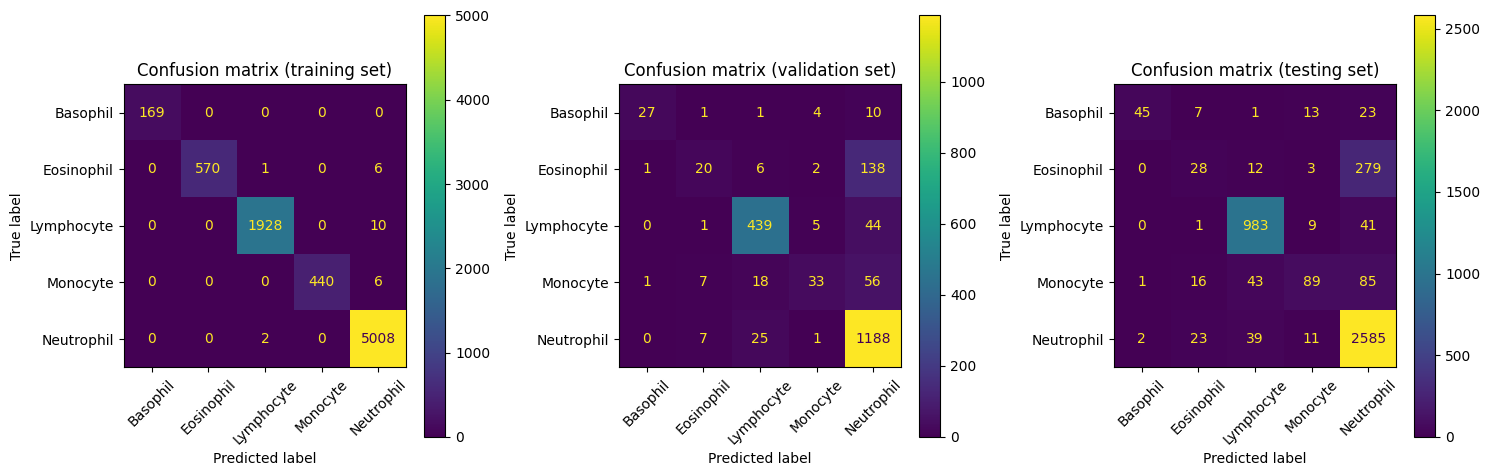

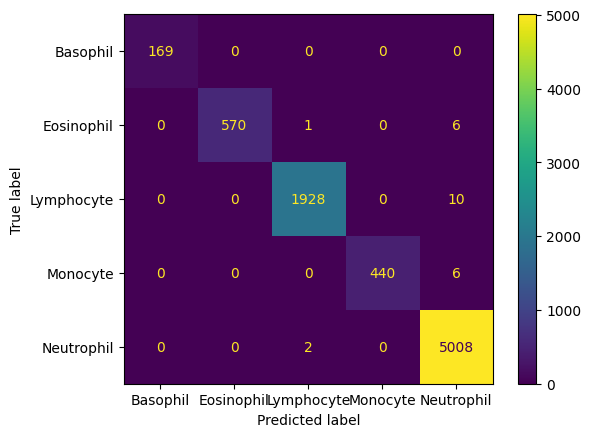

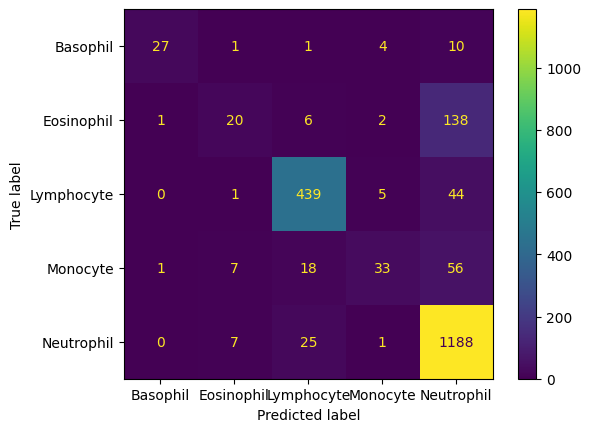

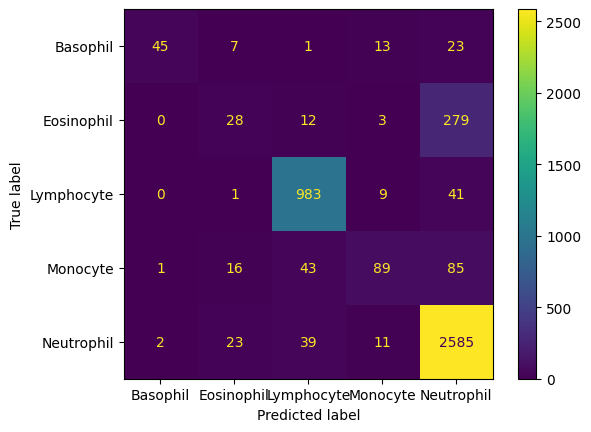

In [8]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

# print('Confusion matrix (training set):')
cm = ConfusionMatrixDisplay.from_predictions(y_train, y_pred_train, display_labels=label_names  )
cm.plot(ax=ax[0])
ax[0].set_title('Confusion matrix (training set)')

# print('Confusion matrix (validation set):')
cm = ConfusionMatrixDisplay.from_predictions(y_val, y_pred_val, display_labels=label_names)
cm.plot(ax=ax[1])
ax[1].set_title('Confusion matrix (validation set)')

# print('Confusion matrix (testing set):')
cm = ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test, display_labels=label_names)
cm.plot(ax=ax[2])
ax[2].set_title('Confusion matrix (testing set)')

for a in ax:
    a.set_xticklabels(a.get_xticklabels(), rotation=45)

fig.tight_layout()
plt.show()

# GGB

In [9]:
label_names = sorted(train_metadata['label'].unique())
X_train, X_test = [], []
for label in tqdm(label_names):
    X_train.append(np.load('../datasets/wbc/clean/hog_features_ggb_train_{}.npz'.format(label))['arr_0'])
    X_test.append(np.load('../datasets/wbc/clean/hog_features_ggb_test_{}.npz'.format(label))['arr_0'])

X_train = np.concatenate(X_train)
X_test  = np.concatenate(X_test)

le = LabelEncoder()
le.fit(train_metadata['label'])
y_train = le.transform(train_metadata['label'])
y_test  = le.transform(test_metadata['label'])

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)


100%|██████████| 5/5 [00:02<00:00,  2.05it/s]


In [10]:
n_jobs = multiprocessing.cpu_count() // 2
print('Num jobs:', n_jobs)

model = xgb.XGBClassifier(
    n_estimators=20,
    random_state=0,
    n_jobs=n_jobs,
    early_stopping_rounds=5
)
model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=True)

Num jobs: 4
[0]	validation_0-mlogloss:1.19349
[1]	validation_0-mlogloss:0.98253
[2]	validation_0-mlogloss:0.84374
[3]	validation_0-mlogloss:0.75257
[4]	validation_0-mlogloss:0.68251
[5]	validation_0-mlogloss:0.63360
[6]	validation_0-mlogloss:0.59015
[7]	validation_0-mlogloss:0.55837
[8]	validation_0-mlogloss:0.53285
[9]	validation_0-mlogloss:0.51300
[10]	validation_0-mlogloss:0.49744
[11]	validation_0-mlogloss:0.48196
[12]	validation_0-mlogloss:0.47095
[13]	validation_0-mlogloss:0.46059
[14]	validation_0-mlogloss:0.45459
[15]	validation_0-mlogloss:0.44856
[16]	validation_0-mlogloss:0.44352
[17]	validation_0-mlogloss:0.43909
[18]	validation_0-mlogloss:0.43527
[19]	validation_0-mlogloss:0.43196


XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=5, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_bin=256, max_cat_threshold=64, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=20, n_jobs=4,
              num_parallel_tree=1, objective='multi:softprob', predictor='auto', ...)

## Metrics

In [11]:
y_pred_train = model.predict(X_train)
y_pred_val   = model.predict(X_val)
y_pred_test  = model.predict(X_test)

train_score  = f1_score(y_train, y_pred_train, average='micro')
val_score    = f1_score(y_val, y_pred_val, average='micro')
test_score   = f1_score(y_test, y_pred_test, average='micro')

print('Training metrics:')
print(classification_report(y_train, y_pred_train, digits=4, target_names=label_names))
print('Validation metrics:')
print(classification_report(y_val, y_pred_val, digits=4, target_names=label_names))
print('Testing metrics:')
print(classification_report(y_test, y_pred_test, digits=4, target_names=label_names))

Training metrics:
              precision    recall  f1-score   support

    Basophil     1.0000    0.9941    0.9970       169
  Eosinophil     1.0000    0.9844    0.9921       577
  Lymphocyte     0.9974    1.0000    0.9987      1938
    Monocyte     1.0000    0.9910    0.9955       446
  Neutrophil     0.9972    0.9990    0.9981      5010

    accuracy                         0.9977      8140
   macro avg     0.9989    0.9937    0.9963      8140
weighted avg     0.9977    0.9977    0.9977      8140

Validation metrics:
              precision    recall  f1-score   support

    Basophil     0.9167    0.5116    0.6567        43
  Eosinophil     0.3966    0.1377    0.2044       167
  Lymphocyte     0.8988    0.9264    0.9124       489
    Monocyte     0.6444    0.2522    0.3625       115
  Neutrophil     0.8390    0.9648    0.8975      1221

    accuracy                         0.8378      2035
   macro avg     0.7391    0.5585    0.6067      2035
weighted avg     0.8077    0.8378    0.

## Conf Matrix

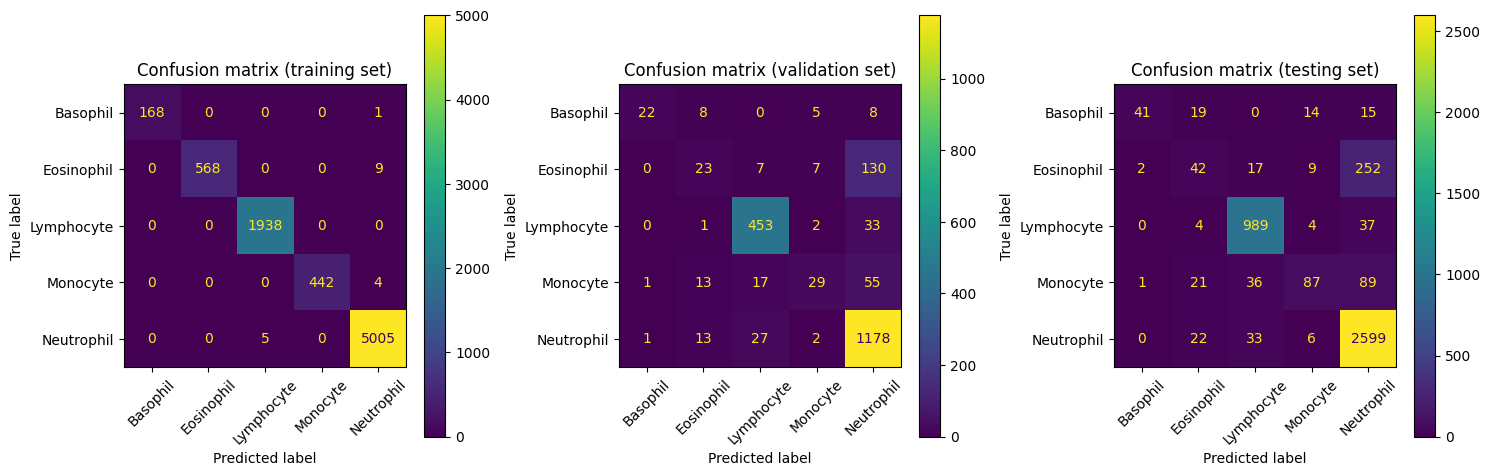

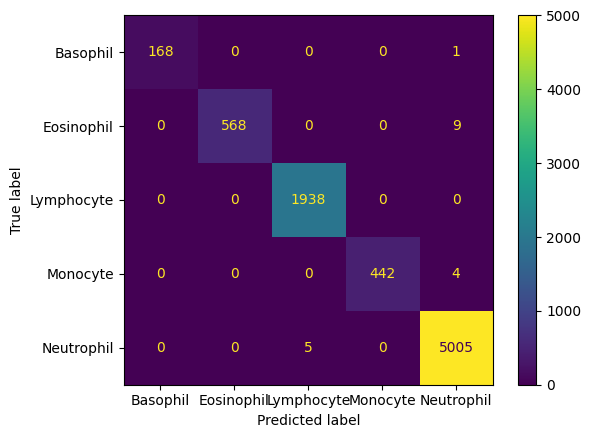

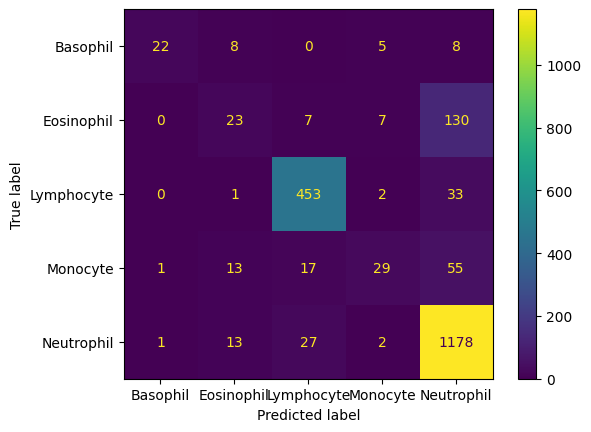

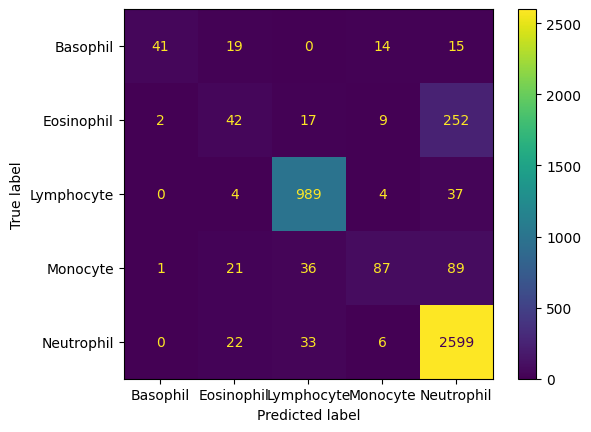

In [14]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

# print('Confusion matrix (training set):')
cm = ConfusionMatrixDisplay.from_predictions(y_train, y_pred_train, display_labels=label_names  )
cm.plot(ax=ax[0])
ax[0].set_title('Confusion matrix (training set)')

# print('Confusion matrix (validation set):')
cm = ConfusionMatrixDisplay.from_predictions(y_val, y_pred_val, display_labels=label_names)
cm.plot(ax=ax[1])
ax[1].set_title('Confusion matrix (validation set)')

# print('Confusion matrix (testing set):')
cm = ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test, display_labels=label_names)
cm.plot(ax=ax[2])
ax[2].set_title('Confusion matrix (testing set)')

for a in ax:
    a.set_xticklabels(a.get_xticklabels(), rotation=45)

fig.tight_layout()
plt.show()

# Plain

In [12]:
label_names = sorted(train_metadata['label'].unique())
X_train, X_test = [], []
for label in tqdm(label_names):
    X_train.append(np.load('../datasets/wbc/clean/hog_features_plain_train_{}.npz'.format(label))['arr_0'])
    X_test.append(np.load('../datasets/wbc/clean/hog_features_plain_test_{}.npz'.format(label))['arr_0'])

X_train = np.concatenate(X_train)
X_test  = np.concatenate(X_test)

le = LabelEncoder()
le.fit(train_metadata['label'])
y_train = le.transform(train_metadata['label'])
y_test  = le.transform(test_metadata['label'])

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)


100%|██████████| 5/5 [00:03<00:00,  1.58it/s]


In [15]:
n_jobs = multiprocessing.cpu_count() // 2
print('Num jobs:', n_jobs)

model = xgb.XGBClassifier(
    n_estimators=20,
    random_state=0,
    n_jobs=n_jobs,
    early_stopping_rounds=5
)
model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=True)

Num jobs: 4
[0]	validation_0-mlogloss:1.18468
[1]	validation_0-mlogloss:0.96813
[2]	validation_0-mlogloss:0.82982
[3]	validation_0-mlogloss:0.73541
[4]	validation_0-mlogloss:0.66455
[5]	validation_0-mlogloss:0.61129
[6]	validation_0-mlogloss:0.56892
[7]	validation_0-mlogloss:0.53788
[8]	validation_0-mlogloss:0.51179
[9]	validation_0-mlogloss:0.49103
[10]	validation_0-mlogloss:0.47449
[11]	validation_0-mlogloss:0.46083
[12]	validation_0-mlogloss:0.45020
[13]	validation_0-mlogloss:0.44141
[14]	validation_0-mlogloss:0.43402
[15]	validation_0-mlogloss:0.43038
[16]	validation_0-mlogloss:0.42567
[17]	validation_0-mlogloss:0.42343
[18]	validation_0-mlogloss:0.41890
[19]	validation_0-mlogloss:0.41489


XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=5, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_bin=256, max_cat_threshold=64, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=20, n_jobs=4,
              num_parallel_tree=1, objective='multi:softprob', predictor='auto', ...)

## Metrics

In [16]:
y_pred_train = model.predict(X_train)
y_pred_val   = model.predict(X_val)
y_pred_test  = model.predict(X_test)

train_score  = f1_score(y_train, y_pred_train, average='micro')
val_score    = f1_score(y_val, y_pred_val, average='micro')
test_score   = f1_score(y_test, y_pred_test, average='micro')

print('Training metrics:')
print(classification_report(y_train, y_pred_train, digits=4))
print('Validation metrics:')
print(classification_report(y_val, y_pred_val, digits=4))
print('Testing metrics:')
print(classification_report(y_test, y_pred_test, digits=4))

Training metrics:
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000       169
           1     1.0000    0.9896    0.9948       577
           2     0.9995    0.9995    0.9995      1938
           3     1.0000    0.9978    0.9989       446
           4     0.9984    0.9998    0.9991      5010

    accuracy                         0.9989      8140
   macro avg     0.9996    0.9973    0.9984      8140
weighted avg     0.9989    0.9989    0.9989      8140

Validation metrics:
              precision    recall  f1-score   support

           0     0.7407    0.4651    0.5714        43
           1     0.5294    0.2156    0.3064       167
           2     0.8982    0.9202    0.9091       489
           3     0.5763    0.2957    0.3908       115
           4     0.8601    0.9722    0.9127      1221

    accuracy                         0.8486      2035
   macro avg     0.7210    0.5737    0.6181      2035
weighted avg     0.8236    0.8486    0.

## Conf Matrix

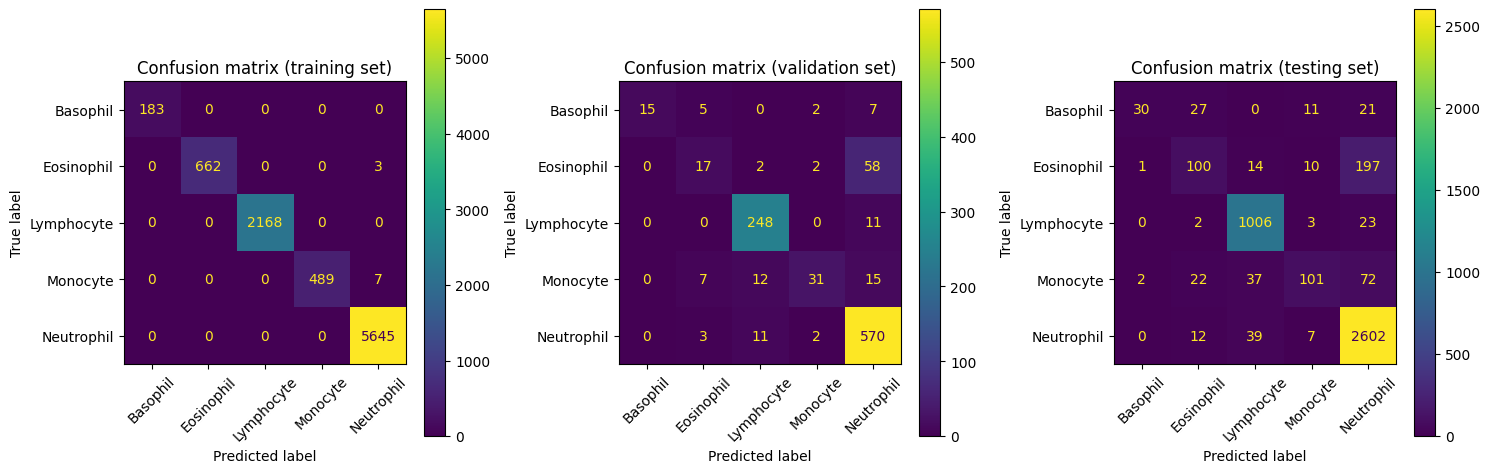

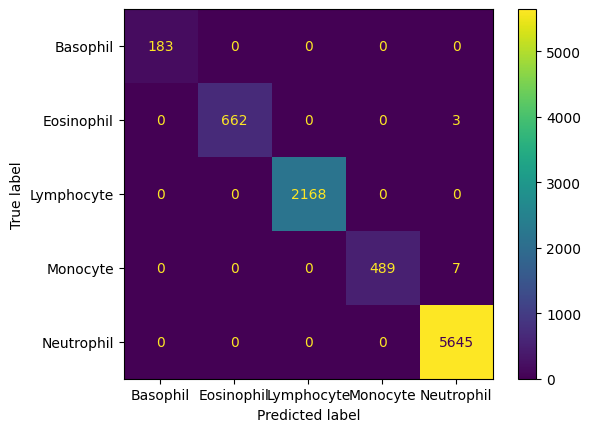

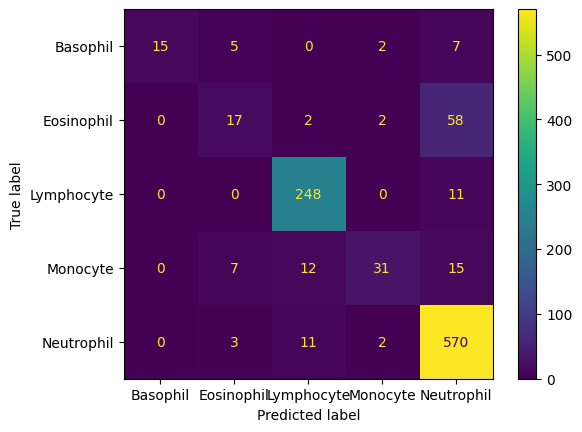

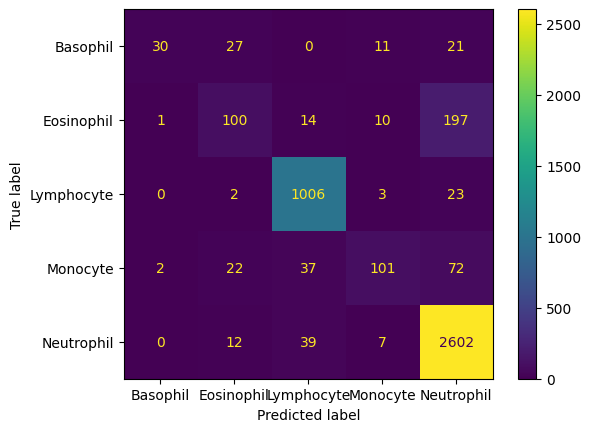

In [37]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

# print('Confusion matrix (training set):')
cm = ConfusionMatrixDisplay.from_predictions(y_train, y_pred_train, display_labels=label_names  )
cm.plot(ax=ax[0])
ax[0].set_title('Confusion matrix (training set)')

# print('Confusion matrix (validation set):')
cm = ConfusionMatrixDisplay.from_predictions(y_val, y_pred_val, display_labels=label_names)
cm.plot(ax=ax[1])
ax[1].set_title('Confusion matrix (validation set)')

# print('Confusion matrix (testing set):')
cm = ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test, display_labels=label_names)
cm.plot(ax=ax[2])
ax[2].set_title('Confusion matrix (testing set)')

for a in ax:
    a.set_xticklabels(a.get_xticklabels(), rotation=45)

fig.tight_layout()
plt.show()